In [1]:
import pandas as pd
import numpy as np
import sklearn

from time import time

from sklearn import metrics
from sklearn.metrics import silhouette_score as sil_score
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.metrics import plot_confusion_matrix, classification_report


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Part I Data loading and pre-processing

In [2]:
file_path = "D:\Github\ML\wine.data"
df_wine = pd.read_csv(file_path, delimiter = ',')
df_wine.columns = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols","Flavanoids", "nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
df_wine.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [3]:
#drop the Ash columns as it is the least reated to the wine class
df_wine.drop('Ash', axis = 1, inplace = True)

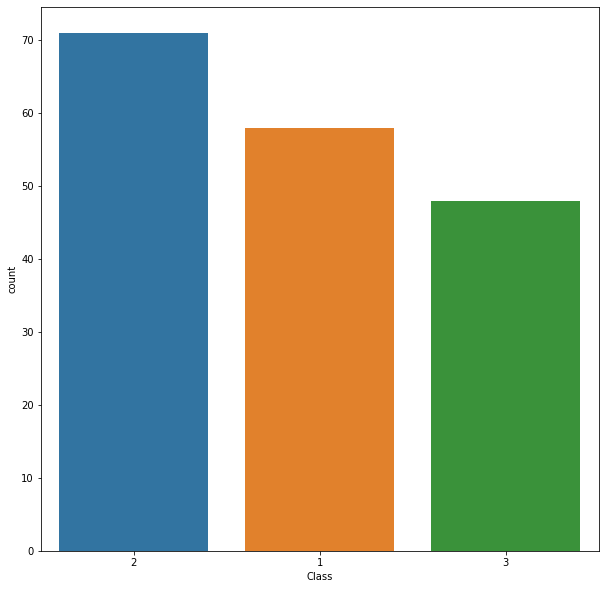

In [4]:
#plot the wine distribution
plt.figure(figsize=(10,10))
sns.countplot(x='Class', data=df_wine, order=df_wine['Class'].value_counts().index);

In [5]:
#create training and testing variables
X = df_wine.drop(['Class'], axis = 1)
y = df_wine['Class']

X_scaled = scale(X)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle = True)

Function

In [6]:
def calculate_null_accuracy(y):
    vals, counts = np.unique(y, return_counts=True)
    
    norm = counts / np.sum(counts)
    
    return max(norm)

def print_line(title=None):
    print(80*'-')
    if title:
        print('* ', title, ' *')
        print(80*'-')

Cluster

help function

In [7]:
# kmeans plot showing elbow method and silhouette score
def kmeans_plot(dataName, data):
    sse = []
    scores = []
    for i in range(2,15):
        kmeans = KMeans(n_clusters=i,init='k-means++', random_state=0)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        
        kmeans_labels = kmeans.predict(data)
        scores.append(sil_score(data, kmeans_labels))
                
    # Plot the data
    title = "K-means of " + dataName
    plt.figure(figsize=(10, 8))
    plt.suptitle(title, y=1.05, fontsize=16)
    
    plt.subplot(211)
    plt.plot(range(2,15),sse, 'x-')
    plt.title("Sum of Squares vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum Square Error')
    plt.grid()
    
    plt.subplot(212)
    plt.plot(range(2,15),scores, 'x-')
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.show()

def em_plot(dataName, data):
    aic = []
    bic = []
    scores = []
    for i in range(2,15):
        gmm = GaussianMixture(n_components=i, random_state=0)
        gmm.fit(data)
        aic.append(gmm.aic(data))
        bic.append(gmm.bic(data))
        
        gmm_labels = gmm.predict(data)
        scores.append(sil_score(data, gmm_labels))
                
    # Plot the data
    title = "Expectation Maximization of " + dataName
    plt.figure(figsize=(10, 8))
    plt.suptitle(title, y=1.05, fontsize=16)
    
    plt.subplot(311)
    plt.plot(range(2,15), aic, 'x-')
    plt.title("AIC Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('AIC')
    plt.grid()
    
    plt.subplot(312)
    plt.plot(range(2,15), bic, 'x-')
    plt.title("BIC Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC')
    plt.grid()
    
    plt.subplot(313)
    plt.plot(range(2,15),scores, 'x-')
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.show()

K-means plot for wine data

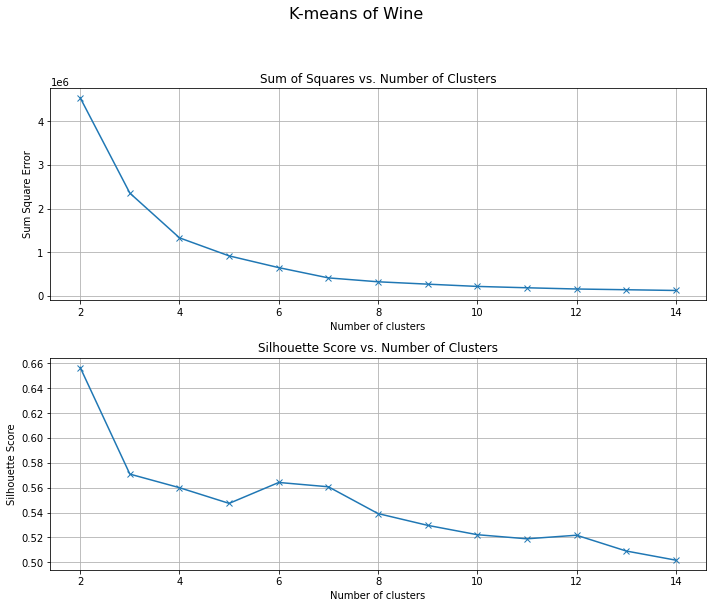

In [8]:
kmeans_plot('Wine', X)

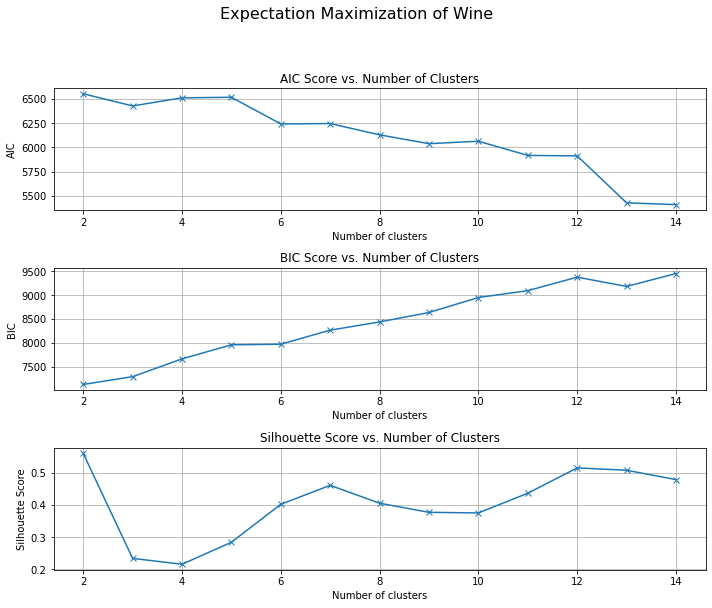

In [9]:
em_plot('Wine', X)

Part II: Dimension Reduction

In [10]:
# Dimensionality reduction imports
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection as RP
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.linalg import pinv
from scipy.stats import kurtosis
from scipy import sparse 


# borrowed from https://github.com/JonathanTay/CS-7641-assignment-3/
def reconstruction_error(algo, data):
    W = algo.components_
    if sparse.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p @ W) @ (data.T)).T
    errors = np.square(data - reconstructed)
    return np.nanmean(errors)

#
# PCA
#

def calc_pca_components(data, dataName):
    t0 = time()
    
    pca = PCA(n_components=data.shape[1], random_state=0)
    pca.fit(data)
    var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
    
    end = time() - t0
    
    plt.title('PCA Analysis for %s' % dataName)
    plt.ylabel('Cumulative % Variance')
    plt.xlabel('Number of Features')
    plt.axhline(y=95, color='gray', linestyle='--', label='95% Variance')
    plt.plot(range(1,data.shape[1]+1), var)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    numComponents = np.argmax(var>95) + 1
    
    
    print('%s total features: %d' %(dataName, data.shape[1]))
    print('Best Number of PCA Components: %d' % numComponents)
    print('Total Time: %.3f seconds' % end)
    
    
#
# ICA
#
def calc_ica_components(data, dataName):
    t0 = time()
    
    dimensions = data.shape[1]+1
    kurtosis = []
    for dim in range(2,dimensions):
        ica = FastICA(n_components=dim, max_iter=600, random_state=0)
        res = ica.fit_transform(data)
        tmp = pd.DataFrame(res)
        k   = tmp.kurt(axis=0)
        kurtosis.append(k.abs().mean())
        
    end = time() - t0
    
    optimalComponents = np.argmax(kurtosis)
    
    plt.title('ICA Analysis for %s' % dataName)
    plt.ylabel('Kurtosis')
    plt.xlabel('Number of Features')
    plt.plot(range(2,dimensions), kurtosis)
    plt.grid()
    plt.show()
    
    print('Total Number of Features:', data.shape[1])
    print('Best Number of ICA Components:', optimalComponents+2)
    print('Total Time: %.3f seconds' % end)
    
    return optimalComponents
    
#
# RP
#
def calc_rp_components(data, dataName, tries=100):
    t0 = time()
    
    dimensions = data.shape[1]+1
    kurtosis = []
    stddev_kurtosis = []
    lowerbound = []
    upperbound = []
    for dim in range(2,dimensions):
        kurts = []
        for t in range(tries):
            rp = RP(n_components=dim)
            res = rp.fit_transform(data)
            tmp = pd.DataFrame(res)
            k   = tmp.kurt(axis=0)
            kurts.append(k.abs().mean())
        kurtosis.append(np.mean(kurts))
        lowerbound.append(np.mean(kurts)-np.std(kurts))
        upperbound.append(np.mean(kurts)+np.std(kurts))
        
    optimalComponents = np.argmax(kurtosis)
    
    end = time() - t0
    
    plt.title('RP Analysis for %s: %d Iterations' % (dataName, tries))
    plt.ylabel('Kurtosis')
    plt.xlabel('Number of Features')
    plt.plot(range(2,dimensions), kurtosis)
    plt.fill_between(range(2, dimensions), lowerbound, upperbound, facecolor='gray', alpha=0.1)
    plt.grid()
    plt.show()
    
    print('Total Number of Features:', data.shape[1])
    print('Best Number of RP Components:', optimalComponents+2)
    print('Total Time: %.3f seconds' % end)
    
    return optimalComponents
    
#
# UFS
#
# function based on https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py
def calc_kbest(dataX, datay, dataName):
    t0 = time()
    
    kBest = SelectKBest(f_classif, k=4)
    kBest.fit(dataX, datay)
    scores = kBest.pvalues_
    scores[np.isnan(scores)]=0 # get rid of NaN's
    scores += 1e-308           # get rid of zero values
    scores = -np.log10(scores)
    scores /= scores.max()
    
    plt.title('UFS Analysis for %s' % dataName)
    plt.ylabel('Normalized Univariate Score')
    plt.xlabel('Feature Number')
    plt.bar(np.arange(dataX.shape[-1]),scores)
    plt.grid(alpha=0.3)
    plt.show()

    end = time() - t0
    print('Total Time: %.3f seconds' % end)


--------------------------------------------------------------------------------
*  Wine PCA  *
--------------------------------------------------------------------------------


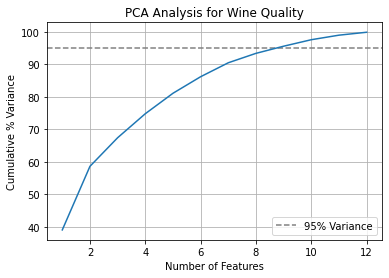

Wine Quality total features: 12
Best Number of PCA Components: 9
Total Time: 0.016 seconds
PCA Reconstruction Error:  9.060233599476946e-31
--------------------------------------------------------------------------------
*  Wine ICA  *
--------------------------------------------------------------------------------


C:\Users\shenl\miniconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\shenl\miniconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\shenl\miniconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\shenl\miniconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('Fast

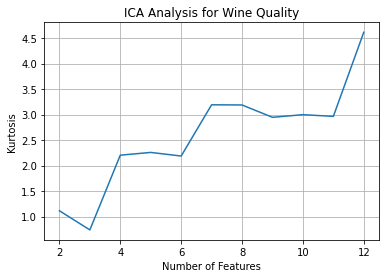

Total Number of Features: 12
Best Number of ICA Components: 12
Total Time: 5.026 seconds


C:\Users\shenl\miniconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


ICA Reconstruction Error:  0.023221912622274108
--------------------------------------------------------------------------------
*  Wine RP  *
--------------------------------------------------------------------------------


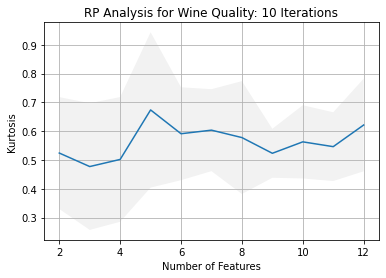

Total Number of Features: 12
Best Number of RP Components: 5
Total Time: 0.386 seconds


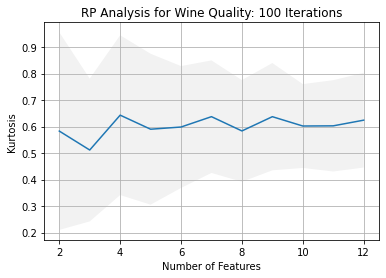

Total Number of Features: 12
Best Number of RP Components: 4
Total Time: 3.183 seconds
ICA Reconstruction Error:  0.7903747058882238
--------------------------------------------------------------------------------
*  Wine UFS  *
--------------------------------------------------------------------------------


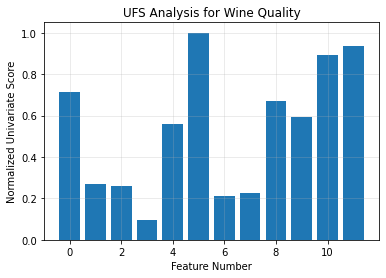

Total Time: 0.387 seconds


In [11]:
# PCA
#
print_line('Wine PCA')
wine_pca_components = calc_pca_components(X_scaled, 'Wine Quality')
winePCA = PCA(n_components=wine_pca_components, random_state=0).fit(X_scaled)
wine_pca_sse = reconstruction_error(winePCA, X_scaled)
print('PCA Reconstruction Error: ', wine_pca_sse)



#
# ICA
#
print_line('Wine ICA')
wine_ica_components = calc_ica_components(X_scaled, 'Wine Quality')
wineICA = FastICA(n_components=wine_ica_components, random_state=0).fit(X_scaled)
wine_ica_sse = reconstruction_error(wineICA, X_scaled)
print('ICA Reconstruction Error: ', wine_ica_sse)


#
# RP
#
print_line('Wine RP')
wine_rp_components = calc_rp_components(X_scaled, 'Wine Quality', 10)
wine_rp_components = calc_rp_components(X_scaled, 'Wine Quality', 100)
wineRP = RP(n_components=wine_rp_components, random_state=0).fit(X_scaled)
wine_rp_sse = reconstruction_error(wineRP, X_scaled)
print('ICA Reconstruction Error: ', wine_rp_sse)


#
# UFS
#
print_line('Wine UFS')
calc_kbest(X_scaled, y, 'Wine Quality')

Part III: Clustering and Dimensional Reduction

Helper Function

In [12]:
# Run all kmeans and plot results
def compare_kmeans(dataName, datasets):
    # Loop through all datasets
    all_sse = []
    all_scores = []
    all_methods = []
    for d in datasets:
        data   = d[1]
        sse    = []
        scores = []
        
        # try different cluster sizes
        for i in range(2,15):
            kmeans = KMeans(n_clusters=i,init='k-means++', random_state=0)
            kmeans.fit(data)
            sse.append(kmeans.inertia_)
            
            kmeans_labels = kmeans.predict(data)
            scores.append(sil_score(data, kmeans_labels))
            
        all_sse.append(sse)
        all_scores.append(scores)
        all_methods.append(d[0])
                    
    # Plot the data
    title = "K-means of " + dataName + " Using Dimensionality Reduction"
    plt.figure(figsize=(10, 8))
    plt.suptitle(title, y=1.05, fontsize=16)
    
    # create method to change line types
    lines = ["o-", "x-", "x--", "x-.", "x:"]
    
    plt.subplot(211)
    for i,sse in enumerate(all_sse):
        plt.plot(range(2,15), sse, lines[i], label=all_methods[i])
    plt.title("Sum of Squares vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum Square Error')
    plt.legend()
    plt.grid()
    
    plt.subplot(212)
    for i, score in enumerate(all_scores):
        plt.plot(range(2,15), score, lines[i], label=all_methods[i])
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

def compare_em(dataName, datasets):
    # Loop through all datasets
    all_aic     = []
    all_bic     = []
    all_scores  = []
    all_dims    = []
    all_methods = []
    for d in datasets:
        data   = d[1]
        dimensions = data.shape[1] + 1
        all_dims.append(list(range(2,dimensions)))
        
        aic    = []
        bic    = []
        scores = []
        
        for i in range(2,dimensions):
            gmm = GaussianMixture(n_components=i, random_state=0)
            gmm.fit(data)
            aic.append(gmm.aic(data))
            bic.append(gmm.bic(data))
        
            gmm_labels = gmm.predict(data)
            scores.append(sil_score(data, gmm_labels))
        
        all_aic.append(aic)
        all_bic.append(bic)
        all_scores.append(scores)
        all_methods.append(d[0])
    
    # Plot the data
    title = "EM of " + dataName + " Using Dimensionality Reduction"
    fig = plt.figure(figsize=(10, 8))
    
    plt.suptitle(title, y=1.05, fontsize=16)
    
    # create method to change line types
    lines = ["o-", "x-", "x--", "x-.", "x:"]
    
    plt.subplot(311)
    for i,aic in enumerate(all_aic):
        plt.plot(all_dims[i], aic, lines[i], label=all_methods[i])
    plt.title("AIC vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('AIC')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(312)
    for i,bic in enumerate(all_bic):
        plt.plot(all_dims[i], bic, lines[i], label=all_methods[i])
    plt.title("BIC Score vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('BIC')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    plt.subplot(313)
    for i,score in enumerate(all_scores):
        plt.plot(all_dims[i], score, lines[i], label=all_methods[i])
    plt.title("Silhouette Score vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def bench_kmeans(estimator, labels, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_, metric='euclidean')))
   
def bench_em(estimator, labels, name, data):
    t0 = time()
    estimator.fit(data)
    gmm_labels = estimator.predict(data)
    print('%-9s\t%.2fs\t%i\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.aic(data), estimator.bic(data),
             metrics.homogeneity_score(labels, gmm_labels),
             metrics.completeness_score(labels, gmm_labels),
             metrics.v_measure_score(labels, gmm_labels),
             metrics.adjusted_rand_score(labels, gmm_labels),
             metrics.adjusted_mutual_info_score(labels,  gmm_labels),
             metrics.silhouette_score(data, gmm_labels, metric='euclidean')))

Wine Data Reduction

In [13]:
# reduce wine data set
winePCA = PCA(n_components=9, random_state=0).fit_transform(X_scaled)
wineICA = FastICA(n_components=8, random_state=0).fit_transform(X_scaled)
wineRP  = RP(n_components=8, random_state=0).fit_transform(X_scaled)
wineUFS = SelectKBest(f_classif, k=4).fit_transform(X_scaled, y)

wine_data = []
wine_data.append(['Original', X_scaled])
wine_data.append(['PCA', winePCA])
wine_data.append(['ICA', wineICA])
wine_data.append(['RP',  wineRP])
wine_data.append(['UFS', wineUFS])

C:\Users\shenl\miniconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K-means

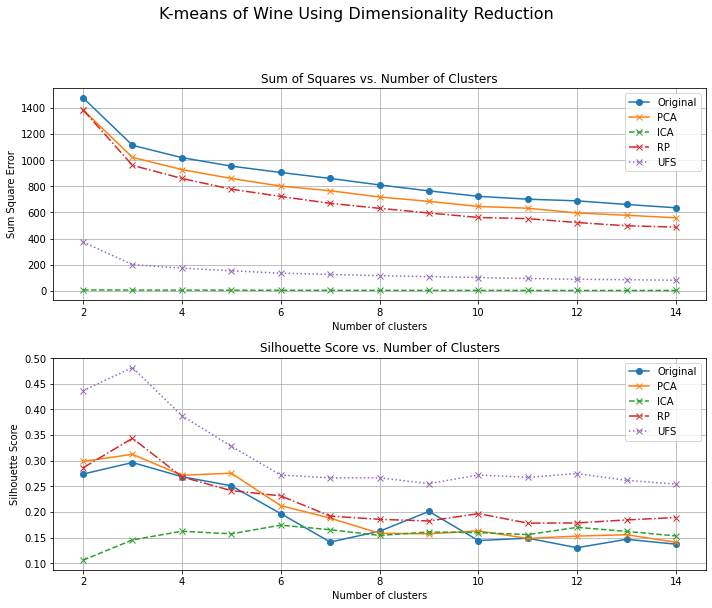

--------------------------------------------------------------------------------
*  K-Means Wine Benchmark  *
--------------------------------------------------------------------------------
init		time	inertia	homog	compl	v-meas	ARI	AMI	silhouette
_____________________________________________________________________________________
Original 	0.12s	1477	0.390	0.612	0.476	0.371	0.473	0.274
PCA-based	0.06s	1385	0.390	0.612	0.476	0.371	0.473	0.286
ICA-based	0.07s	7	0.487	0.821	0.611	0.516	0.608	0.101
RP-based 	0.03s	1384	0.266	0.417	0.325	0.350	0.321	0.286
UFS-based	0.05s	373	0.505	0.843	0.632	0.526	0.630	0.437


In [14]:
# Create k-means plots
compare_kmeans('Wine', wine_data)

# Create k-means benchmark table
print_line('K-Means Wine Benchmark')
print('init\t\ttime\tinertia\thomog\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(85*'_')
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="Original",  data=X_scaled)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="PCA-based", data=winePCA)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="ICA-based", data=wineICA)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="RP-based",  data=wineRP)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="UFS-based", data=wineUFS)


Expectation Maximization

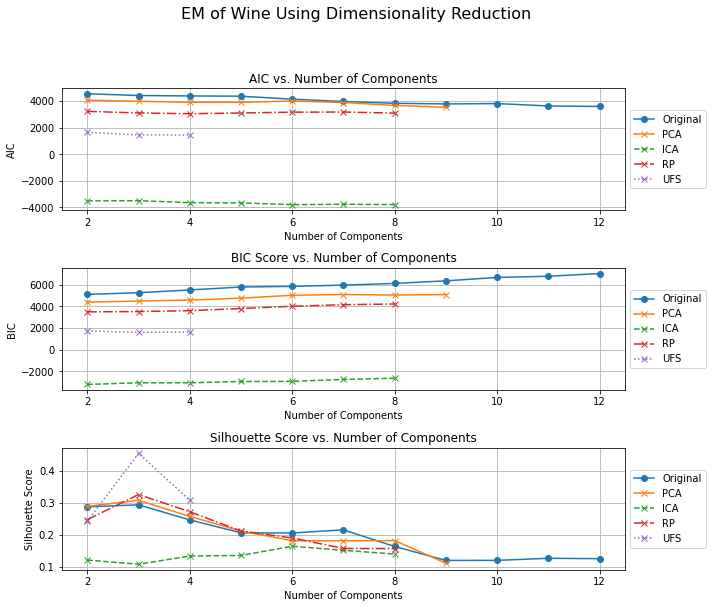

--------------------------------------------------------------------------------
*  EM Wine Benchmark  *
--------------------------------------------------------------------------------
init		time	aic	bic	homog	compl	v-meas	ARI	AMI	silhouette
_____________________________________________________________________________________
Original 	0.10s	3829	6138	0.795	0.446	0.571	0.443	0.559	0.164
PCA-based	0.10s	3669	5063	0.891	0.506	0.646	0.526	0.635	0.183
ICA-based	0.12s	-3792	-2651	0.756	0.415	0.535	0.397	0.522	0.141
RP-based 	0.11s	3090	4230	0.737	0.393	0.513	0.307	0.499	0.158
UFS-based	0.06s	1474	1852	0.853	0.448	0.587	0.364	0.576	0.230


In [15]:
# Create k-means plots
compare_em('Wine', wine_data)

# Create k-means benchmark table
print_line('EM Wine Benchmark')
print('init\t\ttime\taic\tbic\thomog\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(85*'_')
bench_em(GaussianMixture(n_components=8, random_state=0), labels=y, name="Original",  data=X_scaled)
bench_em(GaussianMixture(n_components=8, random_state=0), labels=y, name="PCA-based", data=winePCA)
bench_em(GaussianMixture(n_components=8, random_state=0), labels=y, name="ICA-based", data=wineICA)
bench_em(GaussianMixture(n_components=8, random_state=0), labels=y, name="RP-based",  data=wineRP)
bench_em(GaussianMixture(n_components=8, random_state=0), labels=y, name="UFS-based", data=wineUFS)

Part Four: dimensionality reduction with Neural Networks

Helper Function

In [16]:
# Function based on:
# https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
def plot_learning_curve(clf, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
                                                        clf, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 20),
                                                        return_times = True,
                                                        random_state = 0)

    # ------------------------------------------------------------------------------------------
    # Plot Learning Curve
    # ------------------------------------------------------------------------------------------
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.figure(1)
    plt.plot(train_sizes, train_mean, '--', label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    # Create learning curve plot
    plt.title(title)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    # ------------------------------------------------------------------------------------------
    # Plot Scalability Curve
    # ------------------------------------------------------------------------------------------
    # Create mean and std of training times
    train_times_mean = np.mean(fit_times, axis=1)
    train_times_std  = np.std(fit_times, axis=1)
    
    # plot lines
    plt.figure(2)
    plt.plot(train_sizes, train_times_mean, 'o-')
    plt.fill_between(train_sizes, train_times_mean - train_times_std, train_times_mean + train_times_std, color='#DDDDDD')
    plt.title('Training Scalability')
    plt.xlabel('Training Set Size')
    plt.ylabel('Fit Times (s)')
    plt.grid()
    plt.show()
    
# Function based on:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(clf, X_test, y_test):
    
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                     #display_labels=labels,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        #print(title)
        #print(disp.confusion_matrix)
        plt.show()

    plt.show()
    
    return 0

In [17]:
# split into train and test sets

# reduce wine data set
PCA = PCA(n_components=9, random_state=0).fit_transform(X_scaled)
ICA = FastICA(n_components=8, random_state=0).fit_transform(X_scaled)
RP  = RP(n_components=8, random_state=0).fit_transform(X_scaled)
UFS = SelectKBest(f_classif, k=4).fit_transform(X_scaled, y)

wine_data = []
wine_data.append(['Original', X_scaled])
wine_data.append(['PCA', PCA])
wine_data.append(['ICA', ICA])
wine_data.append(['RP',  RP])
wine_data.append(['UFS', UFS])


C:\Users\shenl\miniconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [18]:
wine_data

[['Original',
  array([[ 0.2558245 , -0.50162433, -2.50010962, ...,  0.40709978,
           1.13169801,  0.97105248],
         [ 0.20622873,  0.01802001, -0.27563874, ...,  0.3195674 ,
           0.80457911,  1.40099798],
         [ 1.70650069, -0.34931478, -0.81672625, ..., -0.4244579 ,
           1.20281081,  2.34050852],
         ...,
         [ 0.34261709,  1.73822194,  0.1452071 , ..., -1.60614514,
          -1.48525319,  0.28632445],
         [ 0.21862767,  0.22408586,  0.1452071 , ..., -1.56237895,
          -1.39991783,  0.30224836],
         [ 1.40892609,  1.57695301,  1.49792588, ..., -1.51861275,
          -1.42836295, -0.58949046]])],
 ['PCA',
  array([[ 2.22560091, -0.18651953,  1.83524221, ...,  0.36435558,
           0.82839068, -0.28282937],
         [ 2.53756722, -0.69096635, -0.99166594, ...,  0.70986319,
          -0.69990285, -0.75551008],
         [ 3.75931414, -2.75297543, -0.47535776, ..., -0.42094143,
           0.78652246, -0.47922056],
         ...,
         [

Neural Network Training

--------------------------------------------------------------------------------
*  Original  *
--------------------------------------------------------------------------------
Neural Net model fit in 93.647 s
Best Score: 0.975 using {'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'solver': 'sgd'}


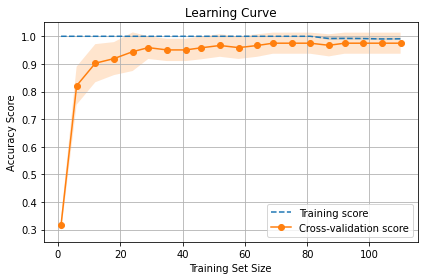

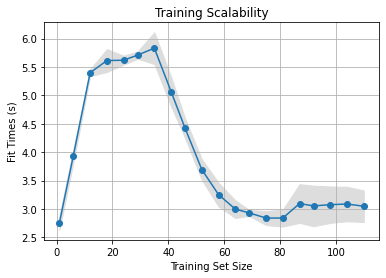

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        19
           2       0.91      0.95      0.93        21
           3       1.00      0.93      0.96        14

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.95        54
weighted avg       0.95      0.94      0.94        54



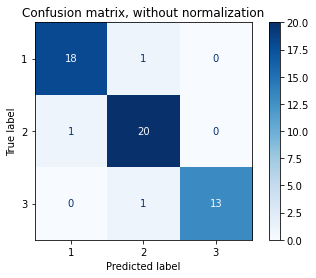

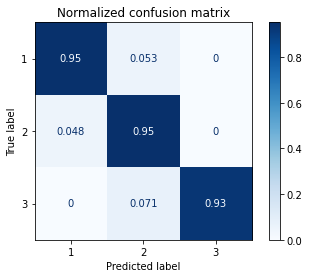

--------------------------------------------------------------------------------
*  PCA  *
--------------------------------------------------------------------------------
Neural Net model fit in 72.337 s
Best Score: 0.967 using {'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}


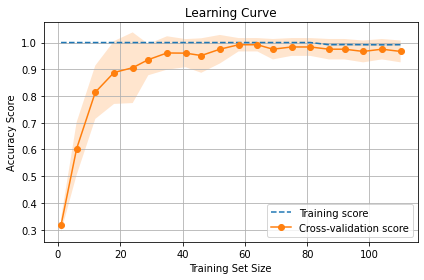

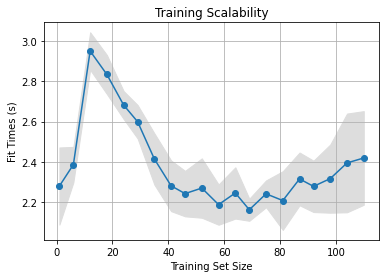

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        19
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



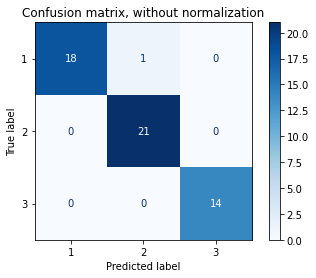

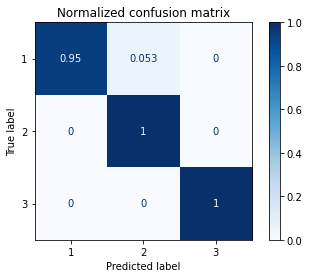

--------------------------------------------------------------------------------
*  ICA  *
--------------------------------------------------------------------------------
Neural Net model fit in 71.388 s
Best Score: 0.975 using {'hidden_layer_sizes': (40, 10), 'learning_rate': 'constant', 'solver': 'sgd'}


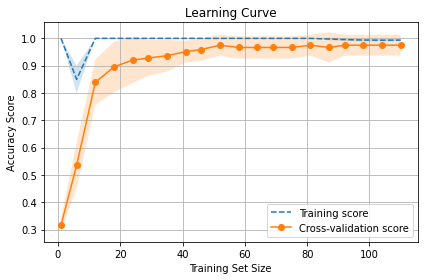

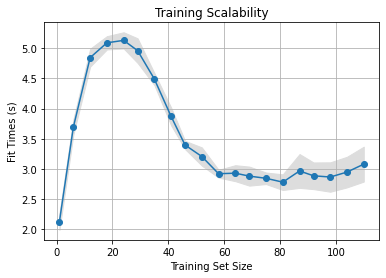

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        19
           2       0.95      0.95      0.95        21
           3       1.00      1.00      1.00        14

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.96      0.96      0.96        54



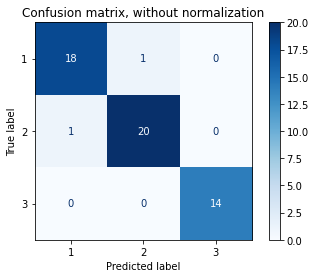

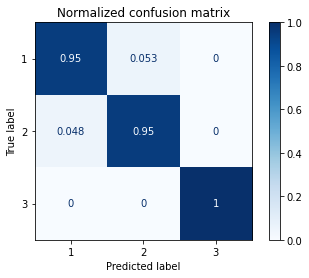

--------------------------------------------------------------------------------
*  RP  *
--------------------------------------------------------------------------------
Neural Net model fit in 79.728 s
Best Score: 0.960 using {'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}


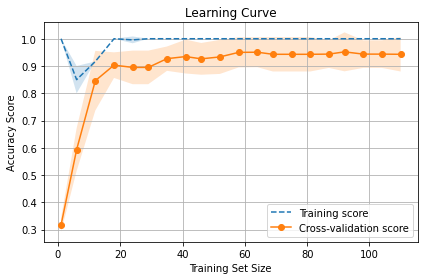

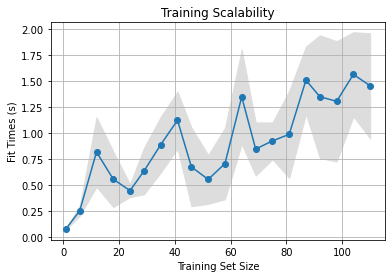

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        19
           2       0.95      0.95      0.95        21
           3       0.93      1.00      0.97        14

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.96      0.96      0.96        54



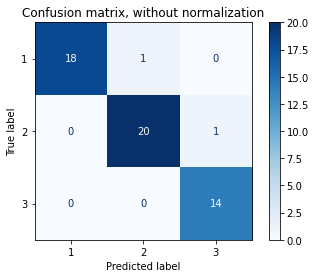

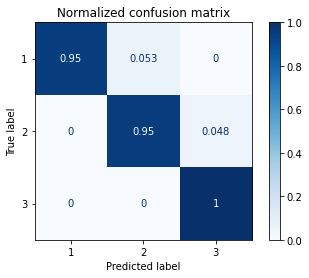

--------------------------------------------------------------------------------
*  UFS  *
--------------------------------------------------------------------------------
Neural Net model fit in 66.480 s
Best Score: 0.951 using {'hidden_layer_sizes': (20, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}


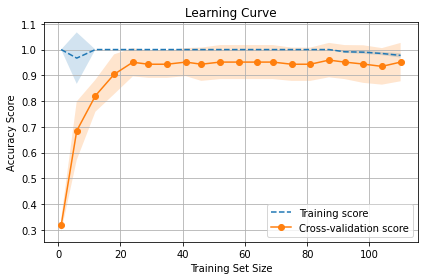

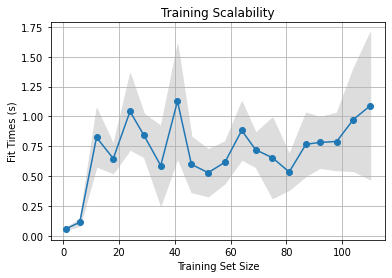

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        19
           2       0.95      0.95      0.95        21
           3       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



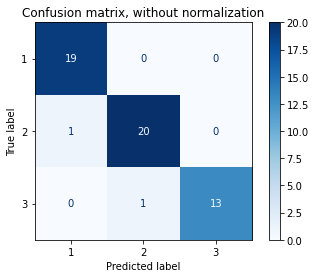

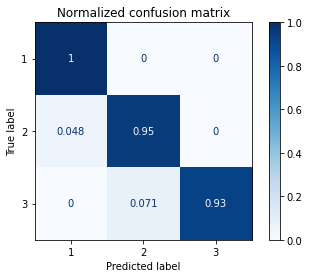

Results
Data:  Original
	Time:    93.64736533164978
	Score:   0.975
	Params:  {'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'solver': 'sgd'}
Data:  PCA
	Time:    72.33699345588684
	Score:   0.9666666666666666
	Params:  {'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}
Data:  ICA
	Time:    71.38846516609192
	Score:   0.9749999999999999
	Params:  {'hidden_layer_sizes': (40, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
Data:  RP
	Time:    79.7278504371643
	Score:   0.9596153846153845
	Params:  {'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Data:  UFS
	Time:    66.48014259338379
	Score:   0.9512820512820515
	Params:  {'hidden_layer_sizes': (20, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [19]:
# Define Grid Search parameters
learning_rates = ['constant', 'invscaling']
solvers = ['sgd', 'lbfgs', 'adam']
layers = [(10,), (20,), (40,), (10,10), (20, 10), (20,20), (40,10), (40,20)]
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}

# define size of test set
test_size=0.3

# collect all results
nn_data = []

for d in wine_data:
    dataName = d[0]
    print_line(dataName)
    
    X1 = d[1]
    y = y
    
    # Scale the data
    X2 = scale(X1)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=test_size, random_state=0)
    
    clf = GridSearchCV(MLPClassifier(max_iter=2000, alpha=1, random_state=0),
                       parameters,
                       cv=10,
                       scoring='accuracy',
                       n_jobs=-1)
                
    t0 = time()
    clf.fit(X_train, y_train)
    nn_time = time() - t0
    
    print("Neural Net model fit in %.3f s" % nn_time)
    print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))
    
    # Create NN with best parameters from grid search
    nn = MLPClassifier(learning_rate=clf.best_params_["learning_rate"],
                       solver=clf.best_params_["solver"],
                       hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"],
                       max_iter=2000,
                       alpha=1,
                       random_state=0)
    
    # plot the learning curve for the data
    plot_learning_curve(nn, X_train, y_train)

    # Predict results using the test set
    nn.fit(X_train, y_train)
    nn_pred = nn.predict(X_test)
    
    # Calculate Null Accuracy
    calculate_null_accuracy(y)
    
    # let's see how our model performed
    print(classification_report(y_test, nn_pred))
    
    plot_confusion(nn, X_test, y_test)
    
    
    # Collect results
    results = {
        "classifier": nn,
        "dataset": dataName,
        "time":    nn_time,
        "score":   clf.best_score_,
        "params":  clf.best_params_
    }
    
    nn_data.append(results)

print('Results')
for res in nn_data:
    print('Data: ',     res["dataset"])
    print('\tTime:   ', res["time"])
    print('\tScore:  ', res["score"])
    print('\tParams: ', res["params"])

NN with Dimensionality Reduction and Clustering Applied to Dataset

K-means

In [20]:
# create dataset

# cluster data and predict labels
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0)
kmeans.fit(X_scaled)
kmeans_labels = kmeans.predict(X_scaled)

label_diff = (kmeans_labels - y)
label_diff = label_diff[label_diff != 0]
print('Correct Labels: %d/%d, %.2f percent' %(len(y)-len(label_diff), len(y), (len(y)-len(label_diff))/len(y)*100))

# add in cluster labels as additional feature
kmeans_wineX = np.c_[X_scaled, kmeans_labels]

X = kmeans_wineX
y = y

Correct Labels: 0/177, 0.00 percent


Neural Net model fit in 79.356 s
Best Score: 0.983 using {'hidden_layer_sizes': (40,), 'learning_rate': 'constant', 'solver': 'sgd'}


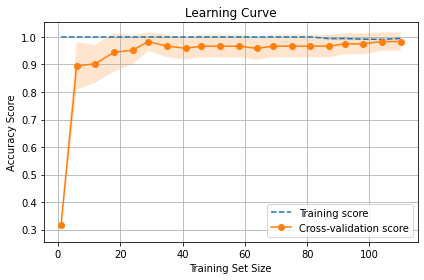

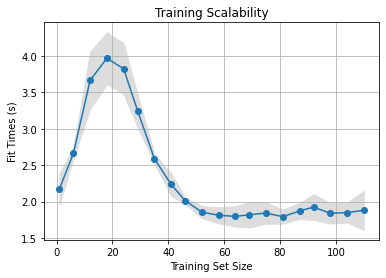

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        19
           2       0.91      1.00      0.95        21
           3       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



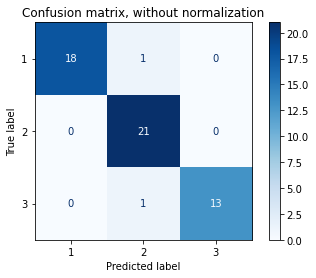

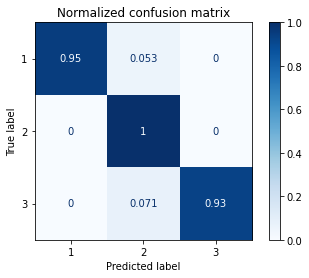

0

In [22]:
# Train Neural net

learning_rates = ['constant', 'invscaling']
solvers = ['sgd', 'lbfgs', 'adam']
layers = [(10,), (20,), (40,), (10,10), (20, 10), (20,20), (40,10), (40,20)]
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = GridSearchCV(MLPClassifier(max_iter=2000, alpha=1, random_state=0),
                   parameters,
                   cv=10,
                   scoring='accuracy',
                   n_jobs=-1)
            
t0 = time()
clf.fit(X_train, y_train)
nn_time = time() - t0

print("Neural Net model fit in %.3f s" % nn_time)
print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))

# Create NN with best parameters from grid search
nn = MLPClassifier(learning_rate=clf.best_params_["learning_rate"],
                   solver=clf.best_params_["solver"],
                   hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"],
                   max_iter=2000,
                   alpha=1,
                   random_state=0)

# plot the learning curve for the data
plot_learning_curve(nn, X_train, y_train)

# Predict results using the test set
nn.fit(X_train, y_train)
nn_pred = nn.predict(X_test)

# Calculate Null Accuracy
calculate_null_accuracy(y)

# let's see how our model performed
print(classification_report(y_test, nn_pred))

plot_confusion(nn, X_test, y_test)

EM methods

In [23]:
# create dataset

# cluster data and predict labels
em = GaussianMixture(n_components=2, random_state=0)
em.fit(X_scaled)
em_labels = em.predict(X_scaled)

label_diff = (em_labels - y)
label_diff = label_diff[label_diff != 0]
print('Correct Labels: %d/%d, %.2f percent' %(len(y)-len(label_diff), len(y), (len(y)-len(label_diff))/len(y)*100))


# add in cluster labels as additional feature
em_wineX = np.c_[X_scaled, em_labels]

X = em_wineX
y = y

Correct Labels: 58/177, 32.77 percent


Neural Net model fit in 78.788 s
Best Score: 0.983 using {'hidden_layer_sizes': (40, 20), 'learning_rate': 'constant', 'solver': 'sgd'}


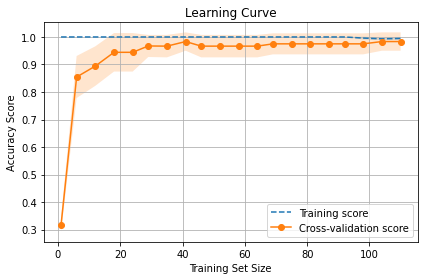

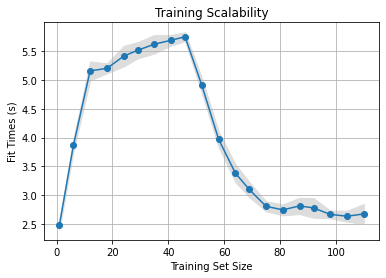

              precision    recall  f1-score   support

           1       1.00      0.95      0.97        19
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



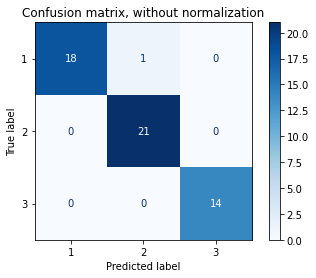

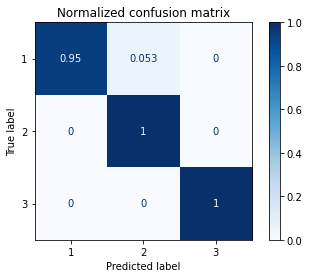

0

In [24]:
# Train Neural net

learning_rates = ['constant', 'invscaling']
solvers = ['sgd', 'lbfgs', 'adam']
layers = [(10,), (20,), (40,), (10,10), (20, 10), (20,20), (40,10), (40,20)]
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = GridSearchCV(MLPClassifier(max_iter=2000, alpha=1, random_state=0),
                   parameters,
                   cv=10,
                   scoring='accuracy',
                   n_jobs=-1)
            
t0 = time()
clf.fit(X_train, y_train)
nn_time = time() - t0

print("Neural Net model fit in %.3f s" % nn_time)
print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))

# Create NN with best parameters from grid search
nn = MLPClassifier(learning_rate=clf.best_params_["learning_rate"],
                   solver=clf.best_params_["solver"],
                   hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"],
                   max_iter=2000,
                   alpha=1,
                   random_state=0)

# plot the learning curve for the data
plot_learning_curve(nn, X_train, y_train)

# Predict results using the test set
nn.fit(X_train, y_train)
nn_pred = nn.predict(X_test)

# Calculate Null Accuracy
calculate_null_accuracy(y)

# let's see how our model performed
print(classification_report(y_test, nn_pred))

plot_confusion(nn, X_test, y_test)